In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from IPython.display import display
from wordcloud import WordCloud

In [2]:
# For expanding the view table and matrix to be formed 
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [3]:
# Provide path of the CSV file
file_path = r"C:\Users\mrunm\OneDrive\Desktop\archive\anthems.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


In [4]:
df.head(200)

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."
5,Belgium,BE,BEL,Europe,"O dear Belgium, O holy land of the fathers Ã¢â..."
6,Bosnia and Herzegovina,BA,BIH,Europe,You're the light of the soul Eternal fire's fl...
7,Bulgaria,BG,BGR,Europe,"Proud Balkan Mountains, next to it the Danube ..."
8,Croatia,HR,HRV,Europe,"Our beautiful homeland, Oh so fearless and gra..."
9,Cyprus,CY,CYP,Europe,"We knew thee of old, O, divinely restored, By ..."


In [5]:
anthems = df["Anthem"]

In [6]:
# Define a regular expression pattern to match symbols
pattern = r'[ˈˌəɪɒɔːʊ,.!:;]'

# Initialize WordNetLemmatizer and PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Get the list of stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("will")
stop_words.add('may')
stop_words.add('let')


# Preprocess and tokenize each anthem text
preprocessed_texts = []
for text in anthems:
    
    # Convert text in the 'anthem' column to lowercase
    df['Anthem'] = df['Anthem'].str.lower()
    
    # Tokenize the text
    tokenized_text = word_tokenize(text)

    # Remove stopwords and symbols using regex
    cleaned_tokens = [word for word in tokenized_text if word.lower() not in stop_words]
    cleaned_tokens = [re.sub(pattern, '', word) for word in cleaned_tokens if word]

    # Lemmatize and stem tokens
    lemmatized_and_stemmed_tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in cleaned_tokens]

    # Join tokens into a single string
    preprocessed_texts.append(' '.join(lemmatized_and_stemmed_tokens))


In [7]:
# Set environment variable to avoid memory leak
os.environ["OMP_NUM_THREADS"] = "1"

In [8]:
# Train Word2Vec model on preprocessed texts
word2vec_model = Word2Vec(sentences=preprocessed_texts, vector_size=100, window=5, min_count=1, sg=0)

# Function to aggregate word embeddings for a text
def aggregate_embeddings(text):
    embeddings = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Aggregate word embeddings for each text
text_embeddings = np.array([aggregate_embeddings(text) for text in preprocessed_texts])

# Apply K-means clustering #

# Explicitly set n_init parameter to suppress FutureWarning
kmeans = KMeans(n_clusters=5, n_init=50)  # Adjust n_clusters and n_init as needed

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(text_embeddings)

# Assign cluster labels to DataFrame or do further analysis
df['cluster'] = cluster_labels

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


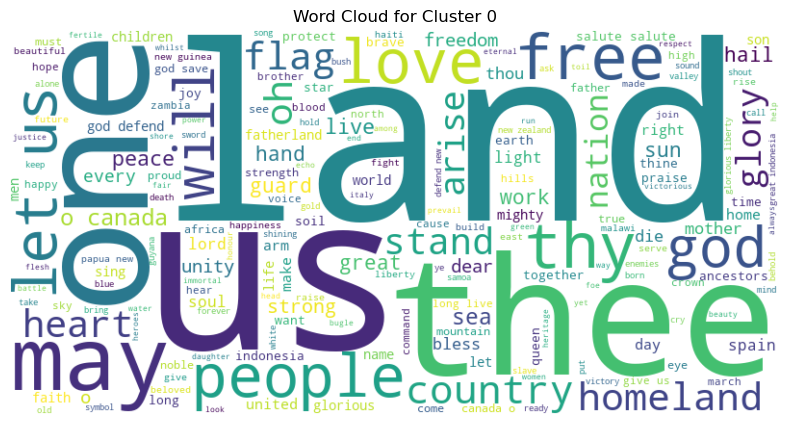

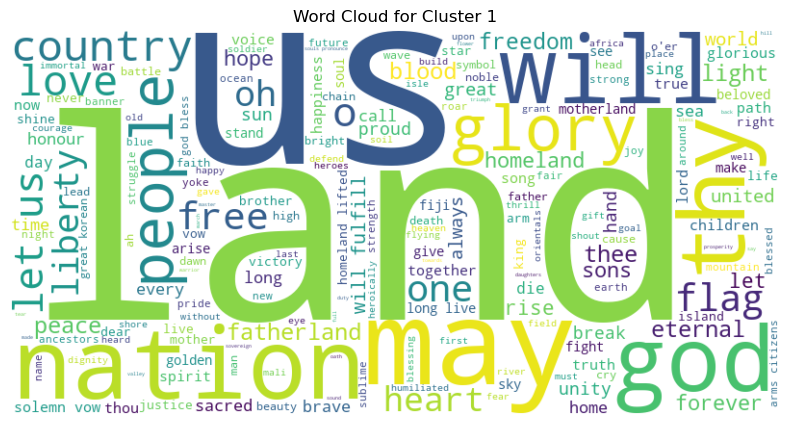

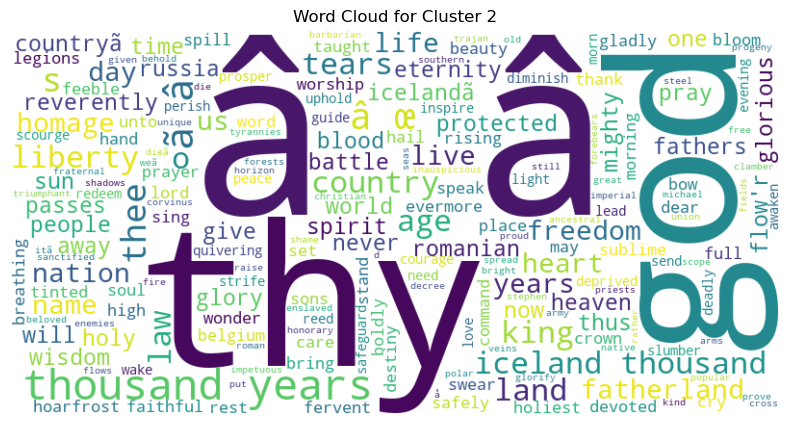

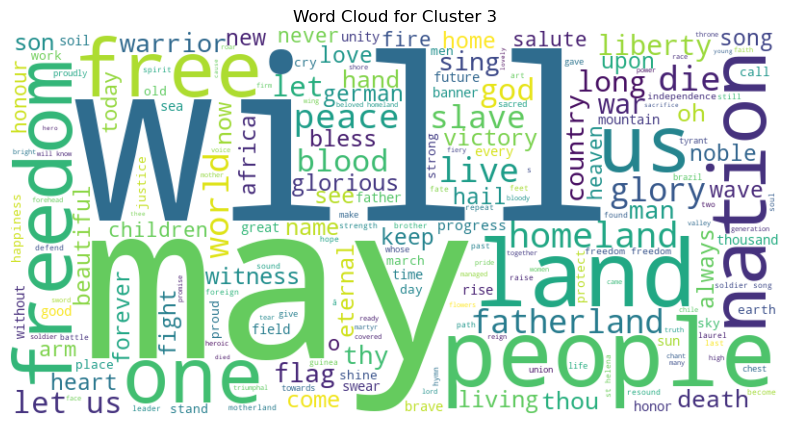

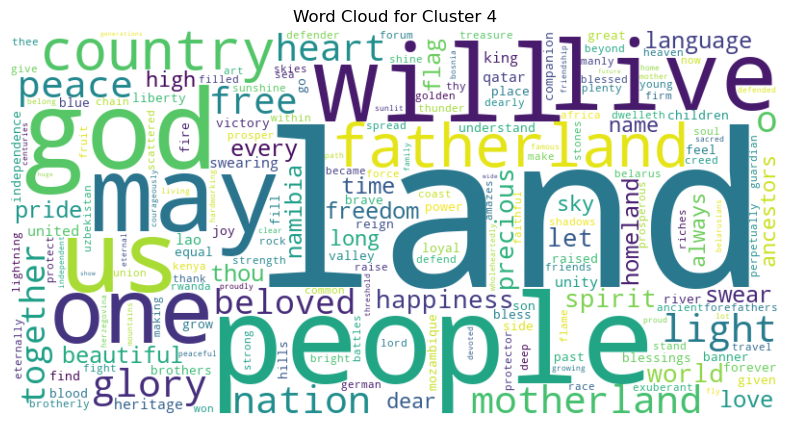

In [9]:
# Group anthem texts by their cluster labels
cluster_texts = df.groupby('cluster')['Anthem'].apply(' '.join)

# Generate word cloud for each cluster
for cluster, text in cluster_texts.items():
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.axis('off')
    plt.show()

In [10]:
# Display the DataFrame with cluster assignments
print(df[['Country', 'cluster']])

                                               Country  cluster
0                                              Albania        1
1                                              Armenia        1
2                                              Austria        1
3                                           Azerbaijan        3
4                                              Belarus        4
5                                              Belgium        2
6                               Bosnia and Herzegovina        4
7                                             Bulgaria        1
8                                              Croatia        0
9                                               Cyprus        0
10                                             Czechia        0
11                                             Denmark        3
12                                             Estonia        4
13                                             Finland        1
14                                      

In [11]:
# Export the DataFrame to an Excel file
output_word2vec = "C:\\Users\\mrunm\\OneDrive\\Desktop\\archive\\output_word2vec.xlsx"
output_word2vec_to_excel = df.to_excel("C:\\Users\\mrunm\\OneDrive\\Desktop\\archive\\output_word2vec.xlsx", index=True)


In [12]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed texts into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)

# Convert TF-IDF matrix to DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# print("TF-IDF Matrix:")
# print(tfidf_df)

# Display the TF-IDF DataFrame
# display(tfidf_df)

# Initialize KMeans with the desired number of clusters
num_clusters = 5  # You can adjust this number based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit KMeans to the TF-IDF matrix
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# print(df.columns)

# Assign cluster labels to anthem texts
df['cluster'] = cluster_labels

# Display the DataFrame with cluster assignments
print(df[['Country', 'Continent', 'Anthem', 'cluster']])

                                               Country      Continent  \
0                                              Albania         Europe   
1                                              Armenia         Europe   
2                                              Austria         Europe   
3                                           Azerbaijan         Europe   
4                                              Belarus         Europe   
5                                              Belgium         Europe   
6                               Bosnia and Herzegovina         Europe   
7                                             Bulgaria         Europe   
8                                              Croatia         Europe   
9                                               Cyprus         Europe   
10                                             Czechia         Europe   
11                                             Denmark         Europe   
12                                             Esto

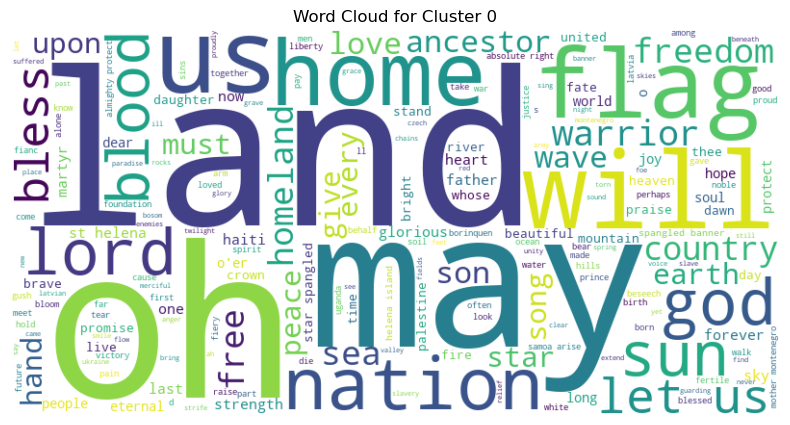

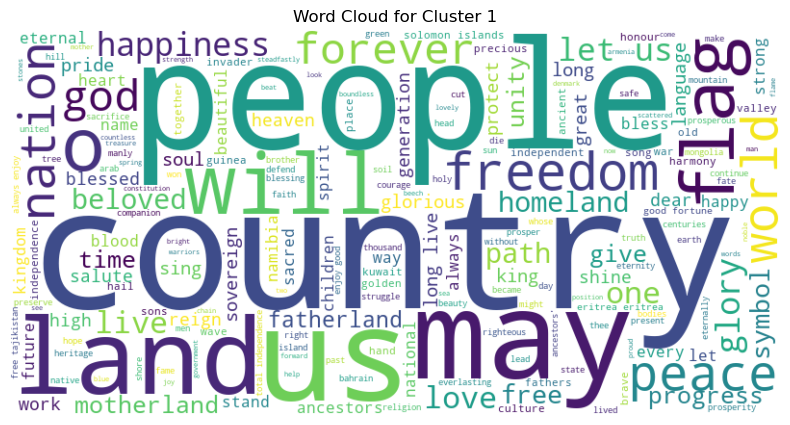

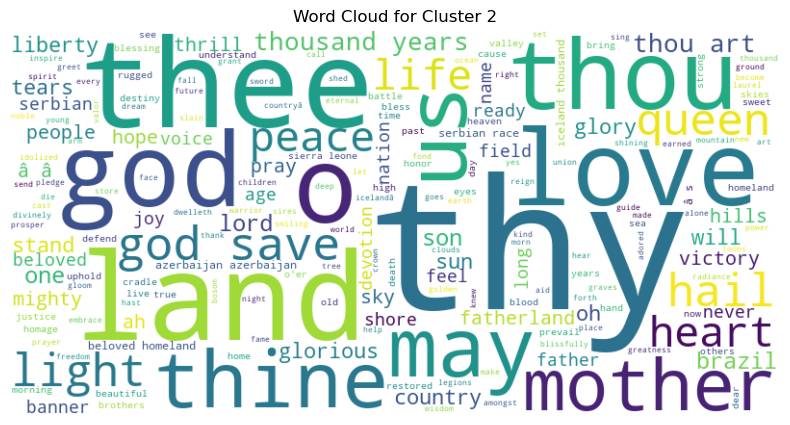

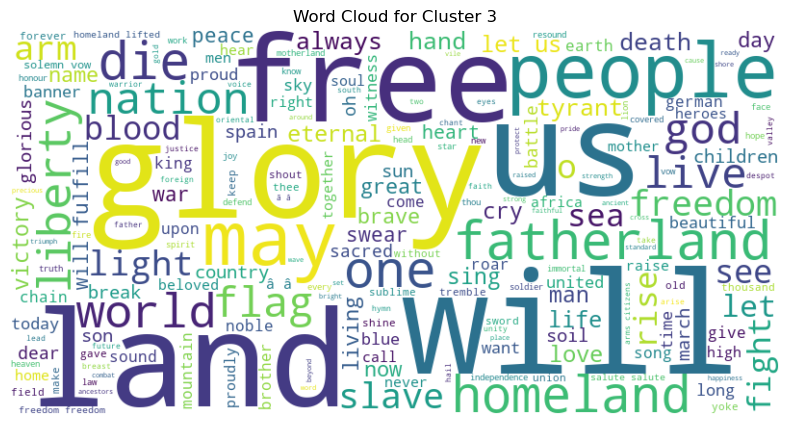

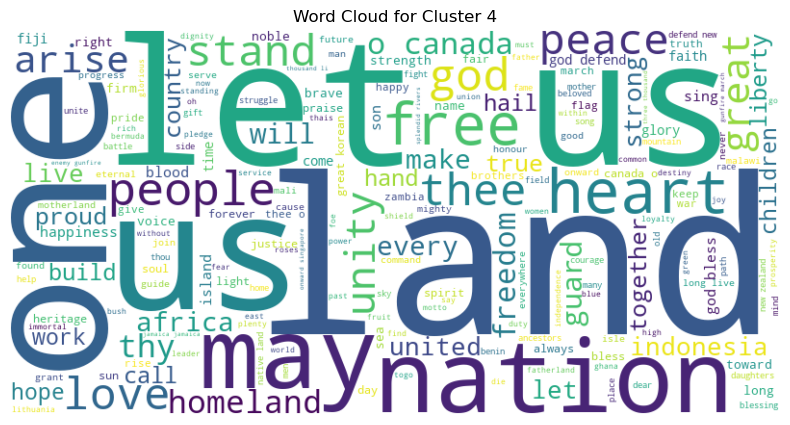

In [13]:
# Group anthem texts by their cluster labels
cluster_texts = df.groupby('cluster')['Anthem'].apply(' '.join)

# Generate word cloud for each cluster
for cluster, text in cluster_texts.items():
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.axis('off')
    plt.show()

In [14]:
# Display the DataFrame with cluster assignments
print(df[['Country', 'cluster']])

                                               Country  cluster
0                                              Albania        3
1                                              Armenia        1
2                                              Austria        3
3                                           Azerbaijan        2
4                                              Belarus        3
5                                              Belgium        3
6                               Bosnia and Herzegovina        4
7                                             Bulgaria        1
8                                              Croatia        3
9                                               Cyprus        2
10                                             Czechia        0
11                                             Denmark        1
12                                             Estonia        3
13                                             Finland        3
14                                      

In [15]:
# Export the DataFrame to an Excel file
output_Tfidf = "C:\\Users\\mrunm\\OneDrive\\Desktop\\archive\\output_Tfidf.xlsx"
output_Tfidf_to_excel = df.to_excel("C:\\Users\\mrunm\\OneDrive\\Desktop\\archive\\output_Tfidf.xlsx", index=True)


In [16]:
# To check if WOrd2vvec and Tf-idf Output are same or not.
import filecmp

def are_files_same(file1_path, file2_path):
    return filecmp.cmp(file1_path, file2_path)

# Example usage:
file1_path = output_word2vec
file2_path = output_Tfidf

if are_files_same(output_word2vec, file2_path):
    print("Files are the same.")
else:
    print("Files are different.")


Files are different.
